In [29]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle
import os

%matplotlib inline
np.random.seed(1)

### 1. Getting Data from the file
    Read the CIFAR data file. This has 5 train batches of size 10K each and one test batch of size 10k.
    Each image is 32*32*3 == 3072
    So each batch has dimension of 10,000*3072

In [30]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [31]:
train_data = [{},{},{},{},{},{}] 
for i in range(1,6):
    train_data[i] = unpickle("/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/cifar-10-batches-py/data_batch_"+str(i))

In [32]:
test_data=unpickle("/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/cifar-10-batches-py/test_batch")

In [33]:
for x in train_data[1]:
  print(x)
print(train_data[i][b'data'].shape)

b'batch_label'
b'labels'
b'data'
b'filenames'
(10000, 3072)


In [34]:
def load_dataset():
    x=[]
    y=[]
    for i in range(1,6):
        x.append(train_data[i][b'data'])
        y.append(train_data[i][b'labels'])
    
    xtr = np.concatenate(x).reshape(50000,3,32,32).transpose(0,2,3,1)
    ytr = np.concatenate(y)
    xte = test_data[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1)
    yte = np.array(test_data[b'labels'])
    
    min_image =  np.min(xtr, axis=0)
    max_image = np.max(xtr, axis = 0)
    xtr = (xtr - min_image) / (max_image-min_image)
    xte = (xte - min_image) / (max_image-min_image)
    
    
    return xtr,ytr,xte,yte,np.arange(9)

In [35]:
def load_outlier_data():
    num_classes = 40
    rootDir = '/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/OutlierTestData'
    X=[]
    flag = 0
    basedir = ""
    
    for dirName, subdirList, fileList in os.walk(rootDir):
        for fname in fileList:
            img = Image.open( dirName+'/'+fname )
            data = np.array( img, dtype='uint8' )
            X.append(data)
    
    return X

In [36]:
def convert_to_onehot(X, num_classes):
    
    num_classes = tf.constant(num_classes, name="num_classes")
    one_hot_matrix = tf.one_hot(X, depth= num_classes, axis= 1)
    session = tf.Session()
    X_one_hot = session.run(one_hot_matrix)
    session.close()
    return X_one_hot

In [37]:
X_train, Y_train, X_test, Y_test, classes = load_dataset()
Y_train = convert_to_onehot(Y_train,10);
Y_test = convert_to_onehot(Y_test,10);
X_outlier = load_outlier_data()
X_outlier = np.array(X_outlier)

In [38]:
print("X_train shape: "+ str(X_train.shape))
print("Y_train shape: "+ str(Y_train.shape))
print("X_test shape: "+ str(X_test.shape))
print("Y_test shape: "+ str(Y_test.shape))
print("X_outlier shape: "+ str(X_outlier.shape))

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)
X_outlier shape: (10, 32, 32, 3)


In [39]:
from sys import getsizeof
X_train.nbytes

1228800000

### 2- Sample Data   
    (Train Data: Test Data) == (80:20)

In [40]:
sample = np.random.randint(low=0, high=50000, size=10000)
X_train_sample = X_train[sample]
Y_train_sample = Y_train[sample]


sample = np.random.randint(low=0, high=10000, size=2000)
X_test_sample = X_test[sample]
Y_test_sample = Y_test[sample]

print("X_train Sample shape: "+ str(X_train_sample.shape))
print("Y_train Sample shape: "+ str(Y_train_sample.shape))
print("X_test Sample shape: "+ str(X_test_sample.shape))
print("Y_test Sample shape: "+ str(Y_test_sample.shape))


X_train Sample shape: (10000, 32, 32, 3)
Y_train Sample shape: (10000, 10)
X_test Sample shape: (2000, 32, 32, 3)
Y_test Sample shape: (2000, 10)


### 3 -  Tensorflow Forward Pass


In [41]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    return X, Y

### 4 - Initialize Filters

In [42]:
def initialize_parameters():
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [3, 3, 3, 64], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", [5, 5, 128, 256], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W4 = tf.get_variable("W4", [5, 5, 256, 512], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3,
                  "W4": W4}
    
    return parameters

### 5- Forward Propagation

In [43]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    
    #layer1
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
#     print("P1:" + str(P1.shape))
    #================================================================================================#
    #layer2
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides= [1,2,2,1], padding='SAME')
#     print("P2:" + str(P2.shape))
    #================================================================================================#
    #layer3
#     print("W3:" + str(W3.shape))
    Z3 = tf.nn.conv2d(P2,W3, strides = [1,1,1,1], padding = 'SAME')
    A3 = tf.nn.relu(Z3)
    P3 = tf.nn.max_pool(A3, ksize=[1,2,2,1], strides= [1,2,2,1], padding='SAME')
#     print("P3:" + str(P3.shape))
    #================================================================================================#
    #layer4
    Z4 = tf.nn.conv2d(P3,W4, strides = [1,1,1,1], padding = 'SAME')
    A4 = tf.nn.relu(Z4)
    P4 = tf.nn.max_pool(A4, ksize=[1,2,2,1], strides= [1,2,2,1], padding='SAME')
#     print("P4:" + str(P4.shape))
    #================================================================================================#
    #layer5
    P5 = tf.contrib.layers.flatten(P4)
#     print("P5:" + str(P5.shape))
    #================================================================================================#
    #layer 6
    Z5 = tf.contrib.layers.fully_connected(P5, 128, activation_fn=tf.nn.relu)
    Z5 = tf.nn.dropout(Z5,0.7)
#     print("Z5:" + str(Z5.shape))
    #================================================================================================#
    #layer 7
    Z6 = tf.contrib.layers.fully_connected(Z5, 256, activation_fn=tf.nn.relu)
    Z6 = tf.nn.dropout(Z6,0.7)
#     print("Z6:" + str(Z6.shape))
    #================================================================================================#
    #layer 8
    Z7 = tf.contrib.layers.fully_connected(Z6, 512, activation_fn=tf.nn.relu)
    Z7 = tf.nn.dropout(Z7,0.7)
#     print("Z7:" + str(Z7.shape))
    #================================================================================================#
    #layer 9
    Z8 = tf.contrib.layers.fully_connected(Z7, 1024, activation_fn=tf.nn.relu)
    Z8 = tf.nn.dropout(Z8,0.7)
#     print("Z8:" + str(Z8.shape))
    #================================================================================================#
    #layer 10
    Z9 = tf.contrib.layers.fully_connected(Z8, 10, activation_fn=None)
#     print("Z9:" + str(Z9.shape))
    return Z9

### 6 - Compute Cost

In [44]:
def compute_cost(Z9, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z9, labels = Y))
    return cost

### 7 - Build Model

In [45]:
def get_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    sample = np.random.randint(low=0, high=m, size=m)
    shuffled_X = X[sample]
    shuffled_Y = Y[sample]
    
    for k in range(0, int(m/mini_batch_size)):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[int(m/mini_batch_size) * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[int(m/mini_batch_size) * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [46]:
import time

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 10, minibatch_size = 128, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape    
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 
    with tf.Session() as sess:
        tr_start_time = time.time()
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = get_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
        save_path = saver.save(sess, "/Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/trained_models/CIFAR_7layer/CIFAR_7layer.ckpt")
        print("Model saved in path: %s" % save_path)
        
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        tr_end_time = time.time()
        #=================================#
        te_start_time = time.time()
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        te_end_time = time.time()
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Training Time: "+ str(tr_end_time - tr_start_time) + " sec")
        print("Train Accuracy:", train_accuracy)
        print("Testing Time: "+ str(te_end_time - te_start_time) + " sec")
        print("Test Accuracy:", test_accuracy)
                
        outlier_predictions = predict_op.eval(feed_dict={X: X_outlier})
    
        return outlier_predictions, train_accuracy, test_accuracy, parameters

### 8 - Compute Run time and Accuracy


In [47]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    outlier_predictions,_, _, parameters = f(*args)
    toc = time.time()
    return outlier_predictions, toc - tic

Cost after epoch 0: 2.178083
Cost after epoch 5: 1.013870
Model saved in path: /Users/dibu/Gatech Academics/BigDataSystems-CS6220/BigDataAssignments/Assignment1/workspace/trained_models/CIFAR_7layer/CIFAR_7layer.ckpt


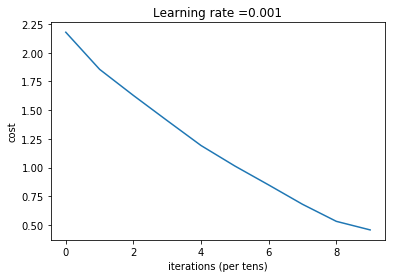

Tensor("Mean_1:0", shape=(), dtype=float32)
Training Time: 2104.526561975479 sec
Train Accuracy: 0.8571
Testing Time: 6.014027833938599 sec
Test Accuracy: 0.5615


In [48]:
outlier_predictions, execution_time = time_function(model, X_train_sample, Y_train_sample, X_test_sample, Y_test_sample)

In [49]:
print("Execution Time: " + str(execution_time) + " sec")

Execution Time: 2119.547956943512 sec


### 9. Outlier Test


In [50]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

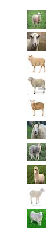

horse
horse
horse
horse
horse
horse
dog
horse
plane
horse


In [51]:
samples_per_class = 10
num_classes = 1
for i in range(10):
    plt_idx = i+1
    plt.subplot(samples_per_class, num_classes, plt_idx)  
    plt.imshow(X_outlier[i].astype('uint8'))
    plt.axis('off')
    i = i+1
plt.show()

for x in np.nditer(outlier_predictions):
    print(classes[x])